In [68]:
import numpy as np
from datetime import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [69]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [70]:
start = datetime(2022, 1, 1)
end = datetime(2025, 1, 1)

bank_tickers = ['SBIN.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'AXISBANK.NS']


df = yf.download(bank_tickers, start, end)['Close']
df.tail()
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  8 of 8 completed


In [71]:
bank_tickers = ['SBIN.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'AXISBANK.NS']

In [72]:
df.loc["2022-01-01" : "2023-01-01"].to_csv('bank_train.csv')
df.loc["2023-01-01" : "2025-01-01"].to_csv('bank_test.csv')

In [73]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [74]:
df_train = pd.read_csv('bank_train.csv', index_col='Date',parse_dates=True)


In [75]:
res = coint_johansen(df_train[bank_tickers], det_order = 1, k_ar_diff = 1)

In [76]:
res.lr1

array([173.34326955, 118.69213613,  82.3005562 ,  54.45114642,
        33.62452429,  19.79995059,   9.04371417,   0.46155552])

In [77]:
res.cvt

array([[169.0618, 175.1584, 187.1891],
       [133.7852, 139.278 , 150.0778],
       [102.4674, 107.3429, 116.9829],
       [ 75.1027,  79.3422,  87.7748],
       [ 51.6492,  55.2459,  62.5202],
       [ 32.0645,  35.0116,  41.0815],
       [ 16.1619,  18.3985,  23.1485],
       [  2.7055,   3.8415,   6.6349]])

In [78]:
res.lr2

array([54.65113342, 36.39157993, 27.84940978, 20.82662213, 13.8245737 ,
       10.75623642,  8.58215865,  0.46155552])

In [79]:
res.cvm

array([[52.5858, 55.7302, 62.1741],
       [46.5583, 49.5875, 55.8171],
       [40.5244, 43.4183, 49.4095],
       [34.4202, 37.1646, 42.8612],
       [28.2398, 30.8151, 36.193 ],
       [21.8731, 24.2522, 29.2631],
       [15.0006, 17.1481, 21.7465],
       [ 2.7055,  3.8415,  6.6349]])

In [80]:
arb_vec = res.evec[0]

In [81]:
df_test = pd.read_csv('bank_test.csv', index_col='Date',parse_dates=True)

In [82]:
import ffn

In [83]:
def backtest(stock_price_df, coeffs, entryZscore, exitZscore):
    stock_names = stock_price_df.keys()
    df = stock_price_df.copy()
    df['spread'] = df[stock_names] @ coeffs
    df['mean_30'] = df['spread'].rolling(window = 60).mean()
    df['std_30'] = df['spread'].rolling(window = 60).std()
    df['z_score'] = (df['spread'] - df['mean_30'])/df['std_30']

    df['long_entry'] = (df.z_score < - entryZscore) & (df.z_score.shift(1) > - entryZscore)
    df['long_exit'] = (df.z_score > - exitZscore) & ( df.z_score.shift(1) < - exitZscore)
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'][0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='pad')

    df['short_entry'] = (df.z_score > entryZscore) & ( df.z_score.shift(1) < entryZscore)
    df['short_exit'] = (df.z_score < exitZscore) & ( df.z_score.shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')

    df['numUnits'] = df['num_units_short'] + df['num_units_short']
    df['spread_pct_chg'] = df.spread.diff()/df.spread
    df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)

    df['cum rets'] = df['port rets'].cumsum()
    df['cum rets'] = df['cum rets'] + 1

    try:
        sharpe = ((df['port rets'].mean() / df['port rets'].std()) * (252) ** 0.5)
    except ZeroDivisionError:
        sharpe = 0.0

    return df['cum rets'], sharpe, df['spread']

In [84]:
from pykalman import KalmanFilter

In [85]:
def KF_Avg(x):
    """Smoothens a stock price series, removing all possible noise"""
    kf = KalmanFilter(transition_matrices = [1], ## System Model: priori_price_on_next_day = price_on_last_day
                      observation_matrices = [1], ## Measuring stock price on the next day
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    try:
        state_means, state_covs = kf.filter(x.values) ## x is assumed to be sequential measurements of the stock price
        state_means = pd.Series(state_means.flatten(), index=x.index)
    except:
        state_means, state_covs = kf.filter(x)
    
    return state_means

In [86]:
def backtest_KF(stock_price_df, coeffs, entryZscore, exitZscore):
    stock_names = stock_price_df.keys()
    df = stock_price_df.copy()
    for s in stock_names:
        df[s] = KF_Avg(df[s])
    df['spread'] = df[stock_names] @ coeffs
    df['mean_30'] = df['spread'].rolling(window = 60).mean()
    df['std_30'] = df['spread'].rolling(window = 60).std()
    df['z_score'] = (df['spread'] - df['mean_30'])/df['std_30']

    df['long_entry'] = (df.z_score < - entryZscore) & (df.z_score.shift(1) > - entryZscore)
    df['long_exit'] = (df.z_score > - exitZscore) & ( df.z_score.shift(1) < - exitZscore)
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'][0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='pad')

    df['short_entry'] = (df.z_score > entryZscore) & ( df.z_score.shift(1) < entryZscore)
    df['short_exit'] = (df.z_score < exitZscore) & ( df.z_score.shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')

    df['numUnits'] = df['num_units_short'] + df['num_units_short']
    df['spread_pct_chg'] = df.spread.diff()/df.spread
    df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)

    df['cum rets'] = df['port rets'].cumsum()
    df['cum rets'] = df['cum rets'] + 1

    try:
        sharpe = ((df['port rets'].mean() / df['port rets'].std()) * (252) ** 0.5)
    except ZeroDivisionError:
        sharpe = 0.0

    return df['cum rets'], sharpe

In [87]:
backtest_KF(df_test[bank_tickers], arb_vec, 2, 0)

(Date
 2023-01-02         NaN
 2023-01-03    1.000000
 2023-01-04    1.000000
 2023-01-05    1.000000
 2023-01-06    1.000000
                 ...   
 2024-12-24    0.848639
 2024-12-26    0.848639
 2024-12-27    0.848639
 2024-12-30    0.848639
 2024-12-31    0.848639
 Name: cum rets, Length: 491, dtype: float64,
 -1.7836701606729999)

In [88]:
for bk in bank_tickers:
    df_train[f"{bk}_smooth"] = KF_Avg(df_train[bk])
    df_test[f"{bk}_smooth"] = KF_Avg(df_test[bk])

<Axes: xlabel='Date'>

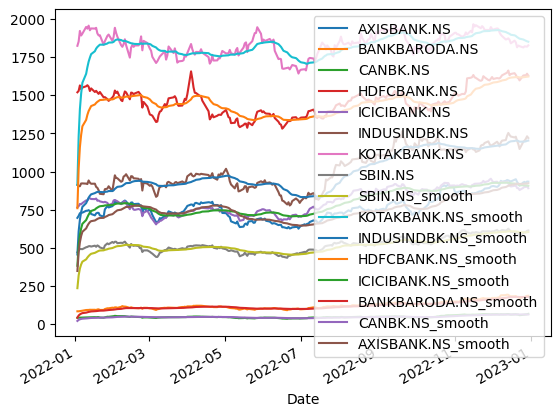

In [89]:
# df_train[bank_tickers].plot()
df_train[df_train.keys()].plot()
# df_train[[f"{bk}_smooth" for bk in bank_tickers].extend(bank_tickers)].plot()

In [90]:
bank_tickers_smooth = [f"{bk}_smooth" for bk in bank_tickers]

In [91]:
ret, sharpe, spread = backtest(df_test[bank_tickers], arb_vec, 1, 0)

start                    2023-01-02 00:00:00
end                      2024-12-31 00:00:00
rf                                       0.0
total_return                             NaN
cagr                                0.230429
max_drawdown                       -0.265271
calmar                              0.868653
mtd                                      0.0
three_month                         0.123138
six_month                           0.233683
ytd                                 0.658331
one_year                            0.658331
three_year                               NaN
five_year                                NaN
ten_year                                 NaN
incep                               0.230429
daily_sharpe                         0.96749
daily_sortino                       1.923444
daily_mean                          0.243844
daily_vol                           0.252038
daily_skew                          3.012393
daily_kurt                         25.400042
best_day  

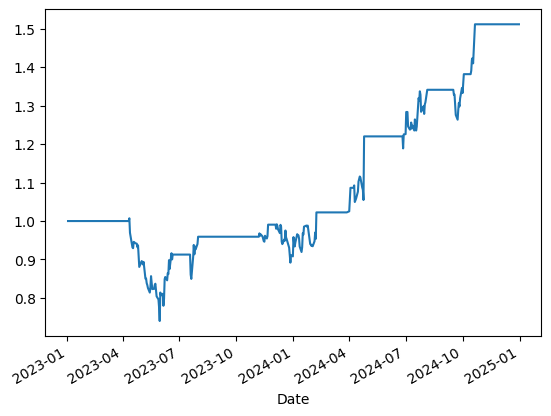

In [92]:
ret.plot()
ret.calc_stats().stats

<Axes: xlabel='Date'>

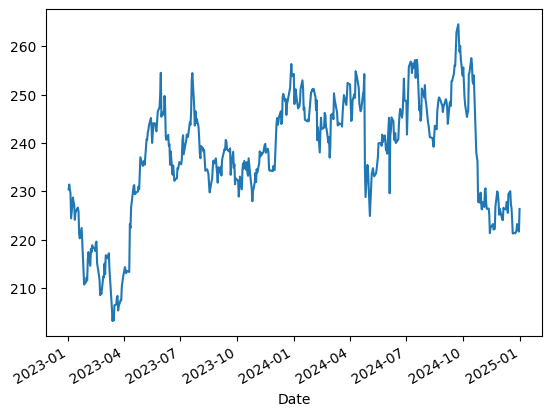

In [93]:
spread.plot()

In [94]:
pharma_tickers = [
    "SUNPHARMA.NS", "DRREDDY.NS", "CIPLA.NS", "DIVISLAB.NS",
    "AUROPHARMA.NS", "BIOCON.NS", "LUPIN.NS", "TORNTPHARM.NS",
    "ZYDUSLIFE.NS", "GLENMARK.NS"
]


start = datetime(2021, 1, 1)
end = datetime(2025, 1, 1)
df = yf.download(pharma_tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  10 of 10 completed


Ticker,AUROPHARMA.NS,BIOCON.NS,CIPLA.NS,DIVISLAB.NS,DRREDDY.NS,GLENMARK.NS,LUPIN.NS,SUNPHARMA.NS,TORNTPHARM.NS,ZYDUSLIFE.NS
Date,,,,,,,,,,
2024-12-24,1262.449951,344.500000,1475.750000,5782.350098,1350.900024,1535.800049,2169.449951,1819.000000,3399.449951,964.799988
2024-12-26,1256.250000,346.450012,1490.550049,5886.750000,1355.150024,1541.449951,2182.100098,1841.349976,3421.350098,957.650024
2024-12-27,1269.949951,352.549988,1506.599976,5881.049805,1389.449951,1585.949951,2227.800049,1861.250000,3405.100098,972.400024
2024-12-30,1298.300049,367.700012,1521.400024,6045.000000,1376.900024,1589.800049,2311.350098,1883.900024,3369.500000,956.950012
2024-12-31,1334.500000,365.350006,1529.000000,6098.799805,1388.500000,1609.099976,2355.699951,1886.349976,3360.050049,971.700012


In [95]:
df.index = pd.to_datetime(df.index)

In [96]:
df.loc["2021-01-01" : "2022-07-01"].to_csv('pharma_train.csv')

In [97]:
df.loc["2022-07-01" : "2025-01-01"].to_csv('pharma_test.csv')

In [98]:
df_train = pd.read_csv('pharma_train.csv', index_col='Date', parse_dates=True)

In [99]:
res = coint_johansen(df_train[pharma_tickers], det_order = 1, k_ar_diff = 2)

In [100]:
res.cvt

array([[251.6293, 259.0267, 273.3838],
       [208.3582, 215.1268, 228.2226],
       [169.0618, 175.1584, 187.1891],
       [133.7852, 139.278 , 150.0778],
       [102.4674, 107.3429, 116.9829],
       [ 75.1027,  79.3422,  87.7748],
       [ 51.6492,  55.2459,  62.5202],
       [ 32.0645,  35.0116,  41.0815],
       [ 16.1619,  18.3985,  23.1485],
       [  2.7055,   3.8415,   6.6349]])

In [101]:
res.lr1

array([263.6446867 , 211.73862917, 165.71671921, 129.91879417,
        94.95405196,  61.97565849,  38.10160436,  18.92405152,
         9.72023355,   3.94074022])

In [102]:
res.cvm

array([[64.5292, 67.904 , 74.7434],
       [58.5316, 61.8051, 68.503 ],
       [52.5858, 55.7302, 62.1741],
       [46.5583, 49.5875, 55.8171],
       [40.5244, 43.4183, 49.4095],
       [34.4202, 37.1646, 42.8612],
       [28.2398, 30.8151, 36.193 ],
       [21.8731, 24.2522, 29.2631],
       [15.0006, 17.1481, 21.7465],
       [ 2.7055,  3.8415,  6.6349]])

In [103]:
res.lr2

array([51.90605753, 46.02190997, 35.79792504, 34.9647422 , 32.97839347,
       23.87405413, 19.17755284,  9.20381797,  5.77949333,  3.94074022])

In [104]:
res.evec[0]

array([ 0.00529621, -0.00247845,  0.01520167,  0.02174808, -0.00629233,
       -0.02877146, -0.00494538, -0.00260943,  0.00397375, -0.00813233])

In [105]:
df_test = pd.read_csv('pharma_test.csv', parse_dates=True, index_col='Date')

In [106]:
ret = backtest(df_test[pharma_tickers], res.evec[0], 1, 0)

<Axes: xlabel='Date'>

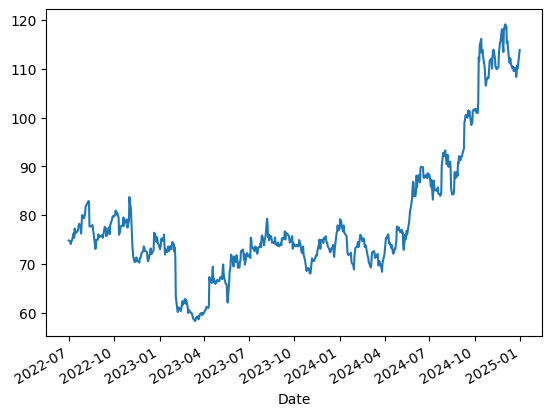

In [107]:
ret[2].plot()

<Axes: xlabel='Date'>

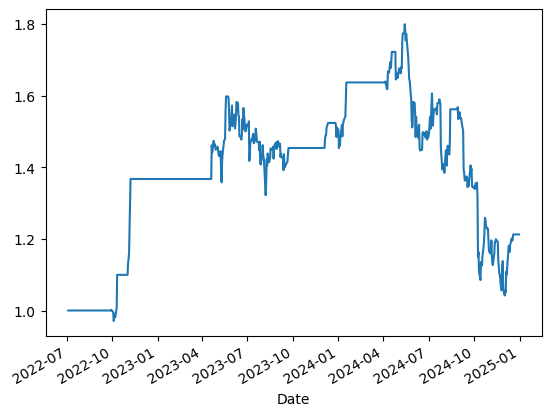

In [108]:
ret[0].plot()

In [109]:
ret[0].calc_stats().stats

start                    2022-07-01 00:00:00
end                      2024-12-31 00:00:00
rf                                       0.0
total_return                             NaN
cagr                                 0.08039
max_drawdown                       -0.421225
calmar                              0.190848
mtd                                 0.145364
three_month                        -0.096893
six_month                          -0.179402
ytd                                -0.198017
one_year                           -0.198017
three_year                           0.08039
five_year                                NaN
ten_year                                 NaN
incep                                0.08039
daily_sharpe                        0.415639
daily_sortino                       0.661409
daily_mean                          0.121294
daily_vol                           0.291825
daily_skew                          1.000535
daily_kurt                         21.040695
best_day  

In [110]:
def KF_linear_regression(x, y):
    """Uses a Kalman Filter to determine the linear regression parameters for stocks x and y"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    ## alpha is intercept, beta is the slope

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y (obs) is 1-dimensional, (beta, alpha) (state) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance = np.ones((2, 2)),
                      transition_matrices = np.eye(2), ## priori params = previous_day_params
                      observation_matrices = obs_mat, ## H of each iteration of the kf algo ** (the observation matrix is not static)
                      observation_covariance = 2, ## 2
                      transition_covariance = trans_cov)
    
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [111]:
x = df_train[['BIOCON.NS', 'CIPLA.NS', 'DIVISLAB.NS', 'DRREDDY.NS',
       'GLENMARK.NS', 'LUPIN.NS', 'SUNPHARMA.NS', 'TORNTPHARM.NS',
       'ZYDUSLIFE.NS']]
y = df_train["AUROPHARMA.NS"]

In [112]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(10) # How much random walk wiggles
filtered_x = x.to_numpy().T
# for i in range(9):
#     filtered_x[i] = KF_Avg(filtered_x[i]).reshape(filtered_x[i].shape)
obs_mat = np.expand_dims(np.vstack([filtered_x, [np.ones(len(x))]]).T, axis=1)

In [113]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=10, # y (obs) is 1-dimensional, (beta, alpha) (state) is 2-dimensional
                      initial_state_mean= np.zeros(10),
                      initial_state_covariance = np.ones((10, 10)),
                      transition_matrices = np.eye(10), ## priori params = previous_day_params
                      observation_matrices = obs_mat, ## H of each iteration of the kf algo ** (the observation matrix is not static)
                      observation_covariance = 2, ## 2
                      transition_covariance = trans_cov)

In [114]:
# y_fil = KF_Avg(y)
state_means, state_covs = kf.filter(y)

In [115]:
x.values.shape

(372, 9)

In [116]:
state_means.shape

(372, 10)

In [117]:
x_big = np.vstack([x.to_numpy().T, [np.ones(len(x))]]).T

In [118]:
spread = y- np.sum( x_big[:, :9] * state_means[:, :9], axis = 1)

In [119]:
df_train['spread'] = spread

<Axes: xlabel='Date'>

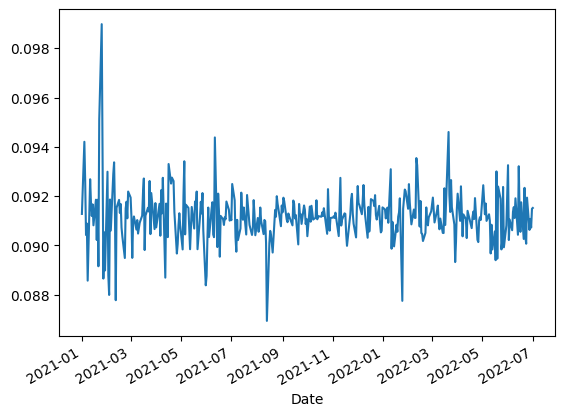

In [120]:
spread.plot()

In [121]:
def backtest_super_KF(stocks_df):
    df = stocks_df.copy()
    stock_names = df.keys()
    num_stocks = len(stock_names)
    x = df[stock_names[1:]]
    y = df[stock_names[0]]
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(num_stocks) # How much random walk wiggles
    filtered_x = x.to_numpy().T
    # for i in range(9):
    #     filtered_x[i] = KF_Avg(filtered_x[i]).reshape(filtered_x[i].shape)
    obs_mat = np.expand_dims(np.vstack([filtered_x, [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=num_stocks, # y (obs) is 1-dimensional, (beta, alpha) (state) is 2-dimensional
                      initial_state_mean= np.zeros(num_stocks),
                      initial_state_covariance = np.ones((num_stocks, num_stocks)),
                      transition_matrices = np.eye(num_stocks), ## priori params = previous_day_params
                      observation_matrices = obs_mat, ## H of each iteration of the kf algo ** (the observation matrix is not static)
                      observation_covariance = 2, ## 2
                      transition_covariance = trans_cov)
    state_means, state_covs = kf.filter(y)
    x_big = np.vstack([x.to_numpy().T, [np.ones(len(x))]]).T
    df['spread'] = y- np.sum( x_big[:, : num_stocks - 1] * state_means[:, : num_stocks - 1], axis = 1)
    df['mean_30'] = df['spread'].rolling(window = 60).mean()
    df['std_30'] = df['spread'].rolling(window = 60).std()
    df['z_score'] = (df['spread'] - df['mean_30'])/df['std_30']

    ## Using the same code from the first backtest function
    entryZscore = 1
    exitZscore = 0

    df['long_entry'] = (df.z_score < - entryZscore) & (df.z_score.shift(1) > - entryZscore)
    df['long_exit'] = (df.z_score > - exitZscore) & ( df.z_score.shift(1) < - exitZscore)
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'][0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='pad')

    df['short_entry'] = (df.z_score > entryZscore) & ( df.z_score.shift(1) < entryZscore)
    df['short_exit'] = (df.z_score < exitZscore) & ( df.z_score.shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')

    df['numUnits'] = df['num_units_short'] + df['num_units_short']
    df['spread_pct_chg'] = df.spread.diff()/df.spread
    df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)

    df['cum rets'] = df['port rets'].cumsum()
    df['cum rets'] = df['cum rets'] + 1

    try:
        sharpe = ((df['port rets'].mean() / df['port rets'].std()) * (252) ** 0.5)
    except ZeroDivisionError:
        sharpe = 0.0

    return df['cum rets'], sharpe, df['spread']
    

In [122]:
res = backtest_super_KF(df_test[pharma_tickers])

In [123]:
spread = res[2]
ret = res[0]

<Axes: xlabel='Date'>

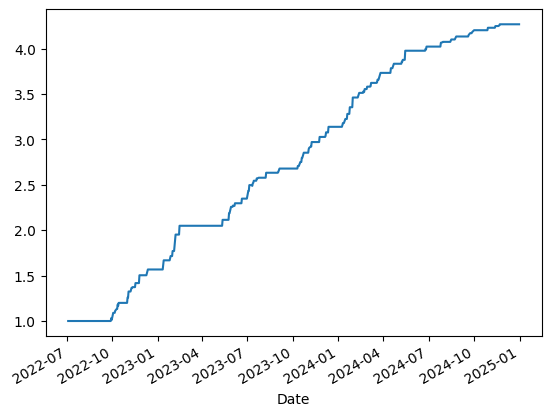

In [124]:
ret.plot()

In [125]:
ret.calc_stats().stats

start                    2022-07-01 00:00:00
end                      2024-12-31 00:00:00
rf                                       0.0
total_return                             NaN
cagr                                 0.78945
max_drawdown                       -0.018779
calmar                              42.03832
mtd                                      0.0
three_month                         0.017116
six_month                           0.061105
ytd                                 0.359829
one_year                            0.359829
three_year                           0.78945
five_year                                NaN
ten_year                                 NaN
incep                                0.78945
daily_sharpe                        4.191992
daily_sortino                      41.383672
daily_mean                          0.606487
daily_vol                           0.144678
daily_skew                          5.400377
daily_kurt                         38.885463
best_day  

In [126]:
df_test = pd.read_csv('bank_test.csv', index_col='Date',parse_dates=True)

In [127]:
res = backtest_super_KF(df_test[bank_tickers])

In [128]:
ret = res[0]
spread = res[2]

<Axes: xlabel='Date'>

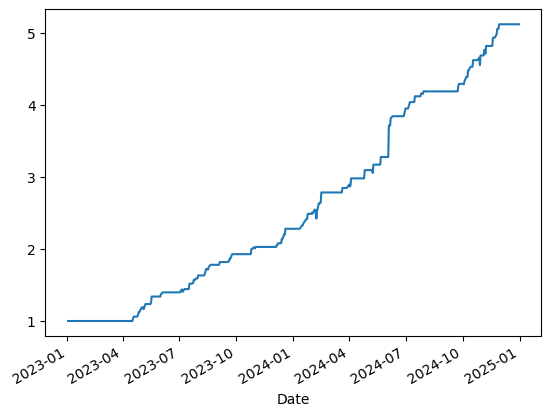

In [129]:
ret.plot()

In [130]:
arbitrary_port_tickers = ['SBIN.NS', 'LUPIN.NS', 'ITC.NS', 'ADANIPORTS.NS', 'RELIANCE.NS']
start = datetime(2021, 1, 1)
end = datetime(2025, 1, 1)
df = yf.download(arbitrary_port_tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  5 of 5 completed


Ticker,ADANIPORTS.NS,ITC.NS,LUPIN.NS,RELIANCE.NS,SBIN.NS
Date,,,,,
2024-12-24,1182.199951,478.450012,2169.449951,1222.750000,812.049988
2024-12-26,1243.949951,476.950012,2182.100098,1216.550049,812.450012
2024-12-27,1230.699951,478.600006,2227.800049,1221.050049,799.650024
2024-12-30,1218.500000,477.000000,2311.350098,1210.699951,788.299988
2024-12-31,1231.099976,483.649994,2355.699951,1215.449951,794.950012


In [131]:
df.head()

Ticker,ADANIPORTS.NS,ITC.NS,LUPIN.NS,RELIANCE.NS,SBIN.NS
Date,,,,,
2021-01-01,503.850006,213.850006,1000.900024,917.230957,279.399994
2021-01-04,498.899994,213.399994,1026.949951,918.776978,281.049988
2021-01-05,499.450012,211.449997,1039.949951,907.354858,281.750000
2021-01-06,496.799988,205.399994,1000.599976,883.426086,285.049988
2021-01-07,513.849976,202.800003,1022.250000,881.995422,287.700012


In [132]:
res = backtest_super_KF(df[arbitrary_port_tickers])

In [133]:
ret = res[0]
spread = res[2]

<Axes: xlabel='Date'>

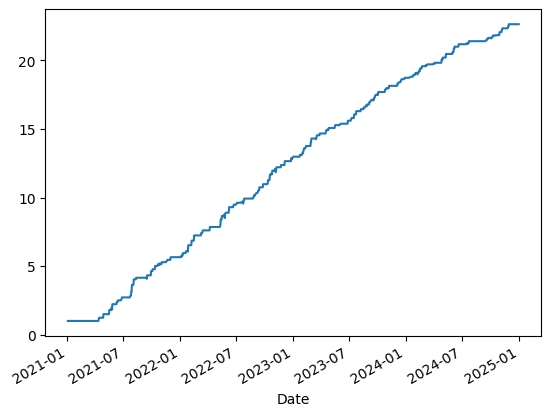

In [134]:
ret.plot()

In [135]:
ret.calc_stats().stats

start                    2021-01-01 00:00:00
end                      2024-12-31 00:00:00
rf                                       0.0
total_return                             NaN
cagr                                1.186133
max_drawdown                       -0.062744
calmar                             18.904383
mtd                                      0.0
three_month                         0.046014
six_month                            0.06884
ytd                                 0.208685
one_year                            0.208685
three_year                          0.588225
five_year                                NaN
ten_year                                 NaN
incep                               1.186133
daily_sharpe                        2.992807
daily_sortino                       22.85141
daily_mean                          0.834715
daily_vol                           0.278907
daily_skew                          8.812149
daily_kurt                         94.422227
best_day  